In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

<h2>Рассмотрим недельный набор данных</h2>

In [29]:
df = pd.read_csv('../data/transformed_data.csv')[:1440 * 14]
df['time'] = pd.to_datetime(df['time'])

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   time                     20160 non-null  datetime64[ns]
 1   power_pump               20160 non-null  float64       
 2   temp_ice                 20160 non-null  float64       
 3   temp_outside             20160 non-null  float64       
 4   hum_outside              20160 non-null  float64       
 5   temp_inside              20160 non-null  float64       
 6   hum_inside               20160 non-null  float64       
 7   max_motion               20160 non-null  float64       
 8   illuminance              20160 non-null  float64       
 9   CO2                      20160 non-null  float64       
 10  temp_condensation        20160 non-null  float64       
 11  consumption_compressors  20160 non-null  float64       
 12  power_compressors        20160 n

In [31]:
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.02, shared_xaxes=True)
fig.add_trace(go.Scatter(x=df['time'], y=df['temp_ice'], name='temp_ice'), row=1, col=1)
fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
                  legend=dict(orientation='h', yanchor='bottom', x=0, y=1.01),
                  font_color='#837A4F',
                  title_font_color='#837A4F'
                  )
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Температура: %{y:.2f}°C', row=1, col=1)
fig.update_yaxes(title_text='°C', row=1, col=1)

In [32]:
temp_ice_arr = df[['temp_ice', 'temp_inside', 'temp_outside', 'temp_return_glycol',
                   'temp_condensation']].to_numpy()
temp_ice_arr

array([[-3.578125  ,  7.14999986, -7.94999981, -5.31      , 13.10366694],
       [-3.609375  ,  7.14999986, -7.94999981, -5.31      , 12.22358354],
       [-3.61914062,  7.14999986, -7.94999981, -5.31      ,  7.81216677],
       ...,
       [-3.621875  ,  7.66249985, -1.9409017 , -5.        , 19.31733354],
       [-3.59375   ,  7.66249985, -1.9409017 , -5.        , 16.95291678],
       [-3.625     ,  7.66249985, -1.9409017 , -5.        , 12.91650009]])

In [33]:
train_mean = temp_ice_arr[:1440 * 5].mean(axis=0)
train_std = temp_ice_arr[:1440 * 5].std(axis=0)

normalized_arr = (temp_ice_arr - train_mean) / train_std

In [34]:
# Формирование признакового пространства для обучения
window_size = 180 # Определение окна для выборки признаков
step_size = 30 # Размер шага прогнозирования
X = []
y = []

for i in range(len(normalized_arr) - window_size - step_size):
    X.append([x for x in normalized_arr[i: i + window_size]])
    y.append([normalized_arr[i + window_size + step_size][0]])

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((19950, 180, 5), (19950, 1))

In [35]:
X[0], y[0]

(array([[ 3.96637569e-01, -5.03437866e-01,  2.53121673e-01,
          4.53702026e-01,  1.56748014e-01],
        [ 3.23791036e-01, -5.03437866e-01,  2.53121673e-01,
          4.53702026e-01, -9.97942915e-02],
        [ 3.01026494e-01, -5.03437866e-01,  2.53121673e-01,
          4.53702026e-01, -1.38571222e+00],
        [ 3.19238127e-01, -5.03437866e-01,  2.53121673e-01,
          4.53702026e-01, -1.49655426e+00],
        [ 3.37449761e-01, -5.03437866e-01,  2.53121673e-01,
          4.53702026e-01, -2.74304307e-01],
        [ 3.55661394e-01, -6.08514554e-01,  2.53121673e-01,
          4.53702026e-01,  1.58326927e-01],
        [ 3.60214302e-01, -6.17092243e-01,  2.53121673e-01,
          4.53702026e-01, -1.80271947e-01],
        [ 3.60214302e-01, -6.25669932e-01,  2.53121673e-01,
          4.53702026e-01, -1.57547728e+00],
        [ 3.60214302e-01, -6.34247621e-01,  2.53121673e-01,
          4.53702026e-01, -1.01218221e+00],
        [ 3.60214302e-01, -6.42825310e-01,  2.53121673e-01,
    

In [36]:
y_train, X_train = y[:1440 * 12], X[:1440 * 12]
y_val, X_val = y[1440 * 12: 1440 * 13], X[1440 * 12: 1440 * 13]
y_test, X_test = y[1440 * 13:], X[1440 * 13:]

In [37]:
X.shape

(19950, 180, 5)

<h2>Обучим простую модель LSTM</h2>

In [38]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

In [39]:
import tensorflow as tf

In [40]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [41]:
model = Sequential()
model.add(InputLayer((180, 5)))
# model.add(LSTM(64))
model.add(Conv1D(64, kernel_size=60))
model.add(Conv1D(64, kernel_size=60))
model.add(LSTM(32))
# model.add(Flatten())
model.add(Dense(50, 'relu'))
model.add(Dense(1, 'linear'))

model._name = 'SimpleCNN_RNN'
model.summary()

Model: "SimpleCNN_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 121, 64)           19264     
                                                                 
 conv1d_3 (Conv1D)           (None, 62, 64)            245824    
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 50)                1650      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 279,205
Trainable params: 279,205
Non-trainable params: 0
_________________________________________________________________


2024-03-13 16:43:48.891182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-13 16:43:48.893174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-13 16:43:48.894797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [42]:
model.compile(loss=MeanSquaredError(), 
              optimizer=Adam(learning_rate=0.0001),
              metrics=[RootMeanSquaredError()])

In [43]:
import os

In [44]:
os.getenv('LD_LIBRARY_PATH')

'/home/aleksandr/miniconda3/envs/tf/lib/:/home/aleksandr/miniconda3/envs/tf/lib/python3.11/site-packages/nvidia/cudnn/lib:/home/aleksandr/miniconda3/envs/tf/lib/:/home/aleksandr/miniconda3/envs/tf/lib/python3.11/site-packages/nvidia/cudnn/lib:/home/aleksandr/miniconda3/envs/tf/lib/:/home/aleksandr/miniconda3/envs/tf/lib/python3.11/site-packages/nvidia/cudnn/lib:/home/aleksandr/miniconda3/envs/tf/lib/:/home/aleksandr/miniconda3/envs/tf/lib/python3.11/site-packages/nvidia/cudnn/lib:/home/aleksandr/miniconda3/envs/tf/lib/:/home/aleksandr/miniconda3/envs/tf/lib/python3.11/site-packages/nvidia/cudnn/lib:/home/aleksandr/miniconda3/envs/tf/lib/:/home/aleksandr/miniconda3/envs/tf/lib/python3.11/site-packages/nvidia/cudnn/lib:/usr/local/cuda-12.3/lib64:/home/aleksandr/my_projects/dissertation/venv/lib/python3.11/site-packages/nvidia/cudnn/lib'

In [45]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10


2024-03-13 16:44:00.431335: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62208000 exceeds 10% of free system memory.
2024-03-13 16:44:00.498225: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62208000 exceeds 10% of free system memory.
2024-03-13 16:44:00.749599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-13 16:44:00.751619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{

535/540 [============================>.] - ETA: 0s - loss: 0.6072 - root_mean_squared_error: 0.7793

2024-03-13 16:44:08.412387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-13 16:44:08.413561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-13 16:44:08.415461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

540/540 [==============================] - 8s 13ms/step - loss: 0.6066 - root_mean_squared_error: 0.7788 - val_loss: 1.3667 - val_root_mean_squared_error: 1.1691
Epoch 2/10
540/540 [==============================] - 6s 12ms/step - loss: 0.4722 - root_mean_squared_error: 0.6872 - val_loss: 1.6259 - val_root_mean_squared_error: 1.2751
Epoch 3/10
540/540 [==============================] - 6s 12ms/step - loss: 0.4028 - root_mean_squared_error: 0.6347 - val_loss: 1.4639 - val_root_mean_squared_error: 1.2099
Epoch 4/10
540/540 [==============================] - 6s 11ms/step - loss: 0.3319 - root_mean_squared_error: 0.5761 - val_loss: 1.4611 - val_root_mean_squared_error: 1.2088
Epoch 5/10
540/540 [==============================] - 5s 10ms/step - loss: 0.3088 - root_mean_squared_error: 0.5557 - val_loss: 1.4079 - val_root_mean_squared_error: 1.1866
Epoch 6/10
540/540 [==============================] - 5s 9ms/step - loss: 0.2496 - root_mean_squared_error: 0.4996 - val_loss: 1.6545 - val_root_m

In [46]:
y_pred_test = model.predict(X_test).flatten()
y_test.shape, y_pred_test.shape

17/39 [============>.................] - ETA: 0s

2024-03-13 16:44:58.440104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-13 16:44:58.441810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-13 16:44:58.443380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 1s 11ms/step


((1230, 1), (1230,))

In [47]:
result_test_df = pd.DataFrame({'y_test': y_test.flatten(), 'y_pred_test': y_pred_test})

<Axes: >

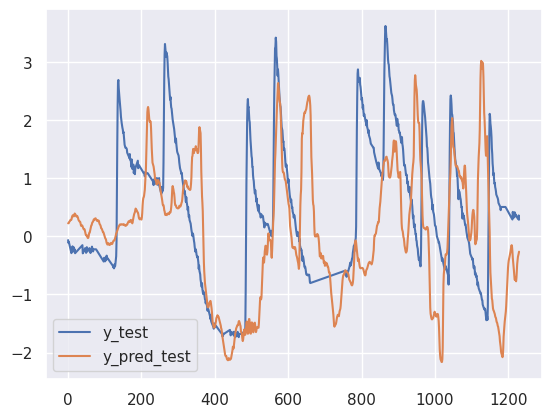

In [49]:
sns.set_theme()
result_test_df.plot()

In [50]:
y_pred = model.predict(X)
y_pred = y_pred * train_std[0] + train_mean[0]

 10/624 [..............................] - ETA: 8s

2024-03-13 16:45:13.154674: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 71820000 exceeds 10% of free system memory.


624/624 [==============================] - 3s 5ms/step


In [51]:
result_df = df[['time', 'temp_ice']].copy()
result_df['prediction'] = np.NaN
result_df.loc[180 + 30:, 'prediction'] = y_pred

In [52]:
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.02, shared_xaxes=True)
fig.add_trace(go.Scatter(x=result_df['time'], y=result_df['temp_ice'], name='temp_ice'), row=1, col=1)
fig.add_trace(go.Scatter(x=result_df['time'], y=result_df['prediction'], name='prediction'), row=1, col=1)
fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
                  legend=dict(orientation='h', yanchor='bottom', x=0, y=1.01),
                  font_color='#837A4F',
                  title_font_color='#837A4F'
                  )
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Температура: %{y:.2f}°C', row=1, col=1)
fig.update_yaxes(title_text='°C', row=1, col=1)

In [53]:
weights = model.get_weights()
len(weights)

11

In [54]:
weights[0].shape

(60, 5, 64)